<a href="https://colab.research.google.com/github/revatishelat/DST_A2/blob/main/report/04_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and load data

In [ ]:
!pip3 install --quiet tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 13.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import transformers as ppb
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
df_train = pd.read_csv('https://raw.githubusercontent.com/sebischair/Medical-Abstracts-TC-Corpus/main/medical_tc_train.csv')

In [ ]:
df_test = pd.read_csv('https://raw.githubusercontent.com/sebischair/Medical-Abstracts-TC-Corpus/main/medical_tc_test.csv')

In [ ]:
def performance(conf_mat):
  TP = 0
  labels = ['NEOPLASMS', 'DIGESTIVE SYSTEM DISEASES', 'NERVOUS SYSTEM DISEASES', 'CARDIOVASCULAR DISEASES', 'GENERAL PATHOLOGICAL CONDITIONS']
  for i in range(conf_mat.shape[0]):
    Class = labels[i]
    tp = conf_mat[i, i]
    fp = np.sum(conf_mat[:, i]) - tp
    fn = np.sum(conf_mat[i, :]) - tp
    tn = np.sum(conf_mat) - (tp + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    TP += tp
    print(Class.upper())
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}")
  accuracy_tot = TP / np.sum(conf_mat)
  print(f"Total Accuracy: {accuracy_tot:.3f}")

# Overview of BERT

BERT (Bidirectional Encoder Representations from Transformers) is a language representation model introduced in 2018 in the paper [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805) by Devlin et al. from Google Research.

Before BERT, language processing models would traditionally process text in one direction, either left-to-right or right-to-left, one word at a time. BERT employs a bidirectional approach, considering both the left and right context of each word to understand their wider context within the input sequence.

BERT completely disrupted the field, beating previous state-of-the-art models, and is now widely used in natural language processing. Although the original paper introduced two versions (a smaller 'Base' model and a larger 'Large' model), there are now many different variations and adaptions in use.

## Model architecture and training

Before being passed to the actual BERT model, input sequences are tokenised by converting each word or piece of a word into an integer code.

The first part of BERT represents these input tokens as vectors through a combination of embeddings.

The second part contains the powerful transformer architecture, which consists of a stack of multi-head self-attention blocks that weigh the importance of words within the sequence.

The original BERT model was trained on two tasks. The first is 'language modelling', in which specific words are masked and the model is trained to predict them. The second is 'next sentence prediction', in which the model is given two sentences and needs to predict whether they appeared concurrently. To perform these tasks, BERT uses the final output from the transformer stack and some specially designed un-embedding module.

Because of this, after BERT is trained, this final output from the transformer stack can be a useful latent representation of the original input sequence.

Our hope and strategy is this: we will use a pre-trained BERT model to embed the medical abstracts from our dataset by taking their output from the transformer stack. This effectively converts each medical abstract to some, hopefully useful, vector representation, and the task is then to classify these.

## Our approaches

In our research, we found many versions of BERT; some are more lightweight versions of the original, while others have been trained to have expertise in specific subject areas. We will implement and/or investigate lightweight models as well as models fine-tuned to text from the medical and biological domains.

# DistilBERT

DistilBERT (proposed in 2019 in [this blog post](https://medium.com/huggingface/distilbert-8cf3380435b5) and [this paper](https://arxiv.org/abs/1910.01108) by Sanh et al.) is effectively a smaller and more computationally efficient version of BERT, created via 'model distillation' of BERT.

Given our limited computing resources and time available, it seemed like a good first choice for trying a BERT model.

We follow [this tutorial](https://colab.research.google.com/github/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb) to load a pre-trained DistilBERT model and attempt to embed the medical abstracts.

## Embedding with pre-trained model

We first load the pre-trained model.

In [ ]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Note that the model comes with its own tokenizer which does its own text preprocessing. We will use this rather than our own preprocessing function, especially since BERT is trained to understand the wider context of a whole input sequence, so we do not want to alter the input sequence before BERT sees it.

DistilBERT has a maximum length for the input sequences it can process, which our medical abstracts exceeded. To combat this, we define a function to truncate the input sequence to a fixed number of words, and apply this to our (training) data.

In [ ]:
def truncate_to_n_words(input_string, n):
    words = input_string.split()[:n]
    truncated_string = ' '.join(words)
    return truncated_string

In [ ]:
X_train_truncated = df_train['medical_abstract'].apply(lambda x: truncate_to_n_words(x, 100))

We then use the tokenizer to process the truncated data. (This takes around a minute on Google Colab.)

In [ ]:
tokenized = X_train_truncated.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

We then get the maximum length of the input sequences and pad the other input sequences so that we can pass in an array of fixed size to the model.

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
np.array(padded).shape

(11550, 282)

However, we generate an attention mask to tell the model where the padding is so it can ignore it.

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(11550, 282)

We then define a function that takes in the `padded` and `attention_mask` arrays, runs them through the model, and takes the last hidden state as our embedding.

Technically, it does this by looking at the specific embedding of the special [CLS] (classify) token that is appended to the input sequence, although we will not go into details here.

In [ ]:
def embed_with_BERT(padded, attention_mask):

  input_ids = torch.tensor(padded)
  attention_mask_tensor = torch.tensor(attention_mask)

  with torch.no_grad():
      last_hidden_states = model(input_ids, attention_mask=attention_mask_tensor)

  return last_hidden_states[0][:,0,:].numpy()

Trying to call this function on the entire processed training dataset causes the code to crash. This is because it runs out of RAM, simply because of the many layers of the BERT model and the large number of data examples we are passing to it.

So instead, we embed the data in batches, as in the code below. WARNING: this takes a long time, as each batch takes a few minutes and there are several of them.

In [ ]:
step = 350 # Batch size

# Uncomment to embed data in batches
# for i in range(0, 11550, step):
#   print(f'Embedding for rows {i} to {i+step}')
#   features_temp = embed_with_BERT(padded[i:i+step], attention_mask[i:i+step])
#   if i == 0:
#     features = features_temp
#   else:
#     features = np.vstack((features, features_temp))

Note in reality that we employed a slightly different code implementation to the above. After processing each batch, we saved the output features as a separate array. We then stitch these all together after processing. An example of this implementation is given in an Appendix.

For now, we can just load the embeddings of the training and test data directly, since we saved them. (Ethan - I have done this by saving them to my Google Drive and mounting this notebook in Google Colab to my Drive. You can also download these embeddings from the GitHub repo.)

In [ ]:
features_train = np.load('/content/drive/MyDrive/University/Bristol/Year 4/clean_embeddings/features_train.npy')

In [ ]:
features_train.shape

(11550, 768)

In [ ]:
features_test = np.load('/content/drive/MyDrive/University/Bristol/Year 4/clean_embeddings/features_test.npy')

In [ ]:
features_test.shape

(2888, 768)

## Classifying

Before we classify, let us examine the embedded data, via a PCA and a t-SNE dimensionality reduction.

We do this just for the first 250 training examples for efficiency and visual clarity.

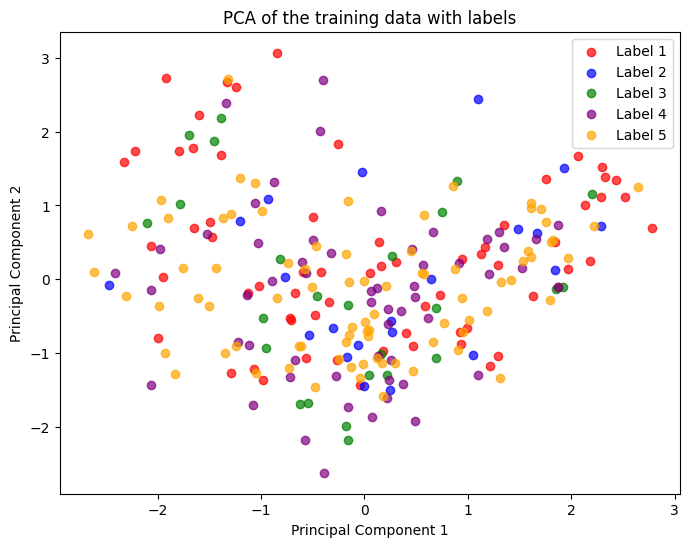

In [ ]:
# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_train[:250])

labels = df_train['condition_label'][:250]

label_colors = {1: 'red', 2: 'blue', 3: 'green', 4: 'purple', 5: 'orange'}

plt.figure(figsize=(8, 6))

for label in np.unique(labels):
    indices = np.where(labels == label)
    plt.scatter(principal_components[indices, 0], principal_components[indices, 1],
                label=f'Label {label}', color=label_colors[label], alpha=0.7)

plt.title('PCA of the training data with labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [ ]:
features_train[:350].shape

(350, 768)

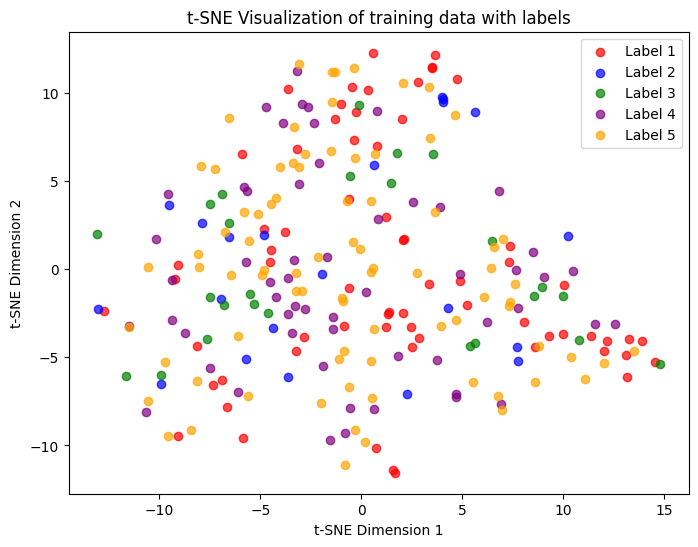

In [ ]:
data = features_train.copy()[:250]
labels = df_train['condition_label'][:250]

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
embedded_data = tsne.fit_transform(data)

# Plot the t-SNE visualization with color-coded labels
plt.figure(figsize=(8, 6))

for label in np.unique(labels):
    indices = np.where(labels == label)
    plt.scatter(embedded_data[indices, 0], embedded_data[indices, 1],
                label=f'Label {label}', color=label_colors[label], alpha=0.7)

plt.title('t-SNE Visualization of training data with labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()

There is no discernible pattern here for distinguishing the classes from each other, which is slightly troubling. We had hoped that the BERT embedding would group similar medical abstracts together.

However, we are only looking at a 2D representation of the embeddings, when in actuality it is 768-dimensional, so there is hope that in this high-dimensional space the data is separable.

We will now attempt to classify the medical abstracts from their BERT embeddings. We define a simple neural network to do this.

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

We did not do a thorough hyperparameter tuning here, but played around with a few values of learning rate and epochs to see what could work. This is since we are more interested in the proof-of-concept as to whether we can get any reasonable results using BERT and a classification head.

In [ ]:
# Set input and output dimensions
input_dim = 768
output_dim = 5

# Create an instance of the model
model = SimpleNN(input_dim, output_dim)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# We played around with scaling the data to be normalised but it did not affect things greatly

# scaler = MinMaxScaler()
# features_train = scaler.fit_transform(features_train)
# features_test = scaler.fit_transform(features_test)

We then train in batches for 100 epochs.

In [ ]:
# Example data (replace with your actual dataset)
num_samples = 11550
input_data = torch.from_numpy(features_train)
labels = torch.from_numpy(df_train['condition_label'].to_numpy().copy())
labels-=1

# Training loop
num_epochs = 100
batch_size = 350

for epoch in range(num_epochs):
    for i in range(0, num_samples, batch_size):
        # Prepare batch
        batch_inputs = input_data[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]

        # Forward pass
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss after each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/50], Loss: 1.3895
Epoch [2/50], Loss: 1.3816
Epoch [3/50], Loss: 1.3905
Epoch [4/50], Loss: 1.3969
Epoch [5/50], Loss: 1.3882
Epoch [6/50], Loss: 1.3853
Epoch [7/50], Loss: 1.3782
Epoch [8/50], Loss: 1.3835
Epoch [9/50], Loss: 1.3892
Epoch [10/50], Loss: 1.3891
Epoch [11/50], Loss: 1.3811
Epoch [12/50], Loss: 1.3832
Epoch [13/50], Loss: 1.3818
Epoch [14/50], Loss: 1.3862
Epoch [15/50], Loss: 1.3794
Epoch [16/50], Loss: 1.3820
Epoch [17/50], Loss: 1.3737
Epoch [18/50], Loss: 1.3838
Epoch [19/50], Loss: 1.3819
Epoch [20/50], Loss: 1.3706
Epoch [21/50], Loss: 1.3722
Epoch [22/50], Loss: 1.3817
Epoch [23/50], Loss: 1.3779
Epoch [24/50], Loss: 1.3830
Epoch [25/50], Loss: 1.3764
Epoch [26/50], Loss: 1.3757
Epoch [27/50], Loss: 1.3850
Epoch [28/50], Loss: 1.3779
Epoch [29/50], Loss: 1.3754
Epoch [30/50], Loss: 1.3723
Epoch [31/50], Loss: 1.3733
Epoch [32/50], Loss: 1.3693
Epoch [33/50], Loss: 1.3729
Epoch [34/50], Loss: 1.3812
Epoch [35/50], Loss: 1.3742
Epoch [36/50], Loss: 1.3741
E

In [ ]:
test_input = torch.from_numpy(features_test)
predicted_probs = model(test_input)
predicted_classes = torch.argmax(predicted_probs, dim=1)

In [ ]:
# Convert PyTorch tensors to NumPy arrays
labels_np = df_test['condition_label'].to_numpy().copy()
labels_np -= 1
predicted_classes_np = predicted_classes.numpy()

# Evaluate the performance
accuracy = accuracy_score(labels_np, predicted_classes_np)
conf_matrix = confusion_matrix(labels_np, predicted_classes_np)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.49965373961218834
Confusion Matrix:
[[483   0   0  21 129]
 [ 45   0   0  51 203]
 [ 42   0   0  63 280]
 [ 23   0   0 389 198]
 [153   0   0 237 571]]


In [ ]:
performance(conf_matrix)

NEOPLASMS
Precision: 0.65, Recall: 0.76
DIGESTIVE SYSTEM DISEASES
Precision: 0.00, Recall: 0.00
NERVOUS SYSTEM DISEASES
Precision: 0.00, Recall: 0.00
CARDIOVASCULAR DISEASES
Precision: 0.51, Recall: 0.64
GENERAL PATHOLOGICAL CONDITIONS
Precision: 0.41, Recall: 0.59
Total Accuracy: 0.500


This performance does not seem great, and the model did not predict any of the data as class 2 or 3. This is likely due to these being the two smallest classes. Since the data is not easily classifiable into the 5 classes, the model prioritises the largest classes since these contribute most to the loss.

Per [this example](https://towardsdatascience.com/feature-extraction-with-bert-for-text-classification-533dde44dc2f), let us also try a random forest classifier.

In [ ]:
X_train = features_train
y_train = df_train['condition_label']

X_test = features_test
y_test = df_test['condition_label']


# Create and train the random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.3275623268698061
Confusion Matrix:
[[322  27  28  30 226]
 [ 58   1   3  29 208]
 [ 36   8  53  44 244]
 [ 38   4  20 201 347]
 [175 102  91 224 369]]


In [ ]:
performance(conf_matrix)

NEOPLASMS
Precision: 0.51, Recall: 0.51
DIGESTIVE SYSTEM DISEASES
Precision: 0.01, Recall: 0.00
NERVOUS SYSTEM DISEASES
Precision: 0.27, Recall: 0.14
CARDIOVASCULAR DISEASES
Precision: 0.38, Recall: 0.33
GENERAL PATHOLOGICAL CONDITIONS
Precision: 0.26, Recall: 0.38
Total Accuracy: 0.328


This results in even worse accuracy overall, although slightly higher precision for classes 2 and 3 since these are now being predicted.

# BERT expert fine-tuned on PubMed

In 2020, Google released several BERT 'expert' models trained on diverse datasets and specific downstream tasks. One in particular (found on [Kaggle](https://www.kaggle.com/models/google/experts-bert/frameworks/tensorFlow2/variations/pubmed) and [GitHub](https://github.com/tensorflow/tfhub.dev/blob/master/assets/docs/google/collections/experts/bert/1.md)) was trained in a self-supervised manner on the [MEDLINE/PubMed](https://www.nlm.nih.gov/databases/download/pubmed_medline.html) corpus, a large database of citations and abstracts of biomedical literature.

Given that our task is concerned with medical text, this also seems like a natural choice of BERT model to try.

## Embedding with pre-trained model

We load the BERT encoder and preprocessing models.

In [ ]:
preprocess = hub.load('https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3')
bert = hub.load('https://www.kaggle.com/models/google/experts-bert/frameworks/TensorFlow2/variations/pubmed/versions/2')

We define a function that takes `bert_inputs`, the preprocessed data, and returns the embedding of the classifier token as the embedding of the whole sequence.

In [ ]:
def embed_with_expert_BERT(bert_inputs):
  bert_outputs = bert(bert_inputs, training=False)
  sequence_output = bert_outputs['sequence_output']
  clf_output = sequence_output[:, 0, :]
  return clf_output

Note that, unlike DistilBERT, we did not have to truncate the input sequences (although this is likely happening behind the scenes).

As before, we get the embeddings by running data through model in batches and saving output by hard-coding.

In [ ]:
abstracts_train_list = list(df_train.medical_abstract)

In [ ]:
step = 350

# Uncomment to get embeddings
# for i in range(0, 11550, step):
#   print(f'Embedding for rows {i} to {i+step}')
#   bert_inputs = preprocess(abstracts_train_list[i:i+step])
#   features_temp = embed_with_expert_BERT(bert_inputs)
#   np.save(f'/content/drive/MyDrive/University/Bristol/Year 4/pubmed_bert_expert/training_embed_{i+step}.npy', features_temp)

We can then load these directly.

In [ ]:
features_train = np.load('/content/drive/MyDrive/University/Bristol/Year 4/pubmed_bert_expert/FULL/training_embed_FULL.npy')

In [ ]:
features_test = np.load('/content/drive/MyDrive/University/Bristol/Year 4/pubmed_bert_expert/FULL/test_embed_FULL.npy')

## Classifying

Again let us perform PCA and t-SNE dimensionality reductions to explore any potential patterns.

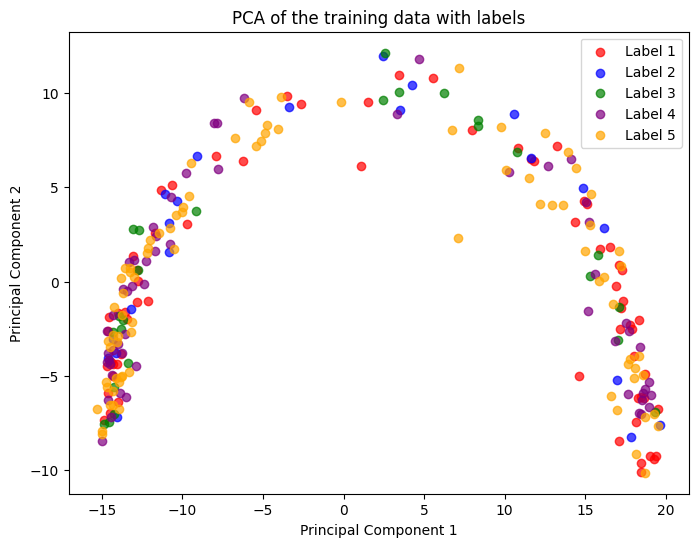

In [ ]:
# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_train[:250])

labels = df_train['condition_label'][:250]

label_colors = {1: 'red', 2: 'blue', 3: 'green', 4: 'purple', 5: 'orange'}

plt.figure(figsize=(8, 6))

for label in np.unique(labels):
    indices = np.where(labels == label)
    plt.scatter(principal_components[indices, 0], principal_components[indices, 1],
                label=f'Label {label}', color=label_colors[label], alpha=0.7)

plt.title('PCA of the training data with labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

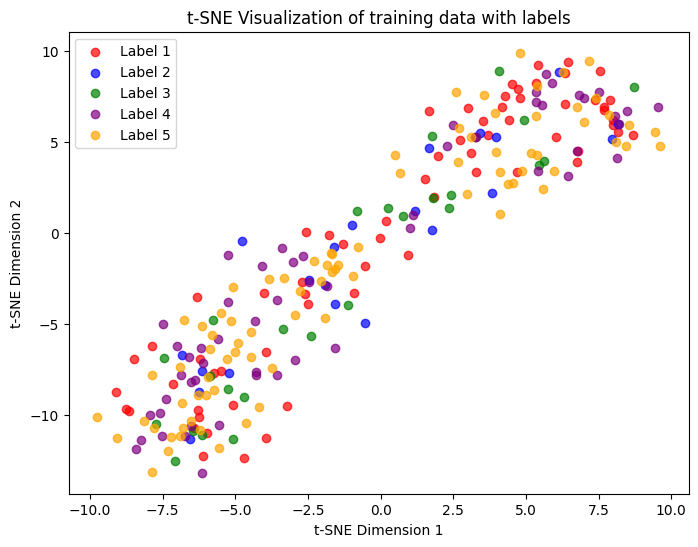

In [ ]:
data = features_train.copy()[:250]
labels = df_train['condition_label'][:250]

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
embedded_data = tsne.fit_transform(data)

# Plot the t-SNE visualization with color-coded labels
plt.figure(figsize=(8, 6))

for label in np.unique(labels):
    indices = np.where(labels == label)
    plt.scatter(embedded_data[indices, 0], embedded_data[indices, 1],
                label=f'Label {label}', color=label_colors[label], alpha=0.7)

plt.title('t-SNE Visualization of training data with labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()

Clearly the whole data has been embedded in a certain geometric way. In the PCA the data falls broadly on a parablic curve and for the t-SNE similarly for a straight line with positive gradient.

However, still no distinctive patterns emerge between the different classes, which may indicate the data is not easily separable.

Again we try a NN classification head.

In [ ]:
# Set input and output dimensions
input_dim = 768
output_dim = 5

# Create an instance of the model
model = SimpleNN(input_dim, output_dim)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=True)

We can start by training for 50 epochs.

In [ ]:
# Example data (replace with your actual dataset)
num_samples = 11550
input_data = torch.from_numpy(features_train)
labels = torch.from_numpy(df_train['condition_label'].to_numpy().copy())
labels-=1

# Training loop
num_epochs = 50
batch_size = 350

for epoch in range(num_epochs):
    for i in range(0, num_samples, batch_size):
        # Prepare batch
        batch_inputs = input_data[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]

        # Forward pass
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss after each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Now we predict on the test data and analyse the performance.

In [ ]:
test_input = torch.from_numpy(features_test)
predicted_probs = model(test_input)
predicted_classes = torch.argmax(predicted_probs, dim=1)

In [ ]:
# Convert PyTorch tensors to NumPy arrays
labels_np = df_test['condition_label'].to_numpy().copy()
labels_np -= 1
predicted_classes_np = predicted_classes.numpy()

# Evaluate the performance
accuracy = accuracy_score(labels_np, predicted_classes_np)
conf_matrix = confusion_matrix(labels_np, predicted_classes_np)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

In [ ]:
performance(conf_matrix)

The next code cell is optional, but we found that by training for many more epochs, we can push model to predict class 3 as well.

In [ ]:
# Example data (replace with your actual dataset)
num_samples = 11550
input_data = torch.from_numpy(features_train)
labels = torch.from_numpy(df_train['condition_label'].to_numpy().copy())
labels-=1

# Training loop
num_epochs = 450
batch_size = 350

for epoch in range(num_epochs):
    for i in range(0, num_samples, batch_size):
        # Prepare batch
        batch_inputs = input_data[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]

        # Forward pass
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss after each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/1000], Loss: 1.5296
Epoch [2/1000], Loss: 1.4845
Epoch [3/1000], Loss: 1.4307
Epoch [4/1000], Loss: 1.4183
Epoch [5/1000], Loss: 1.3838
Epoch [6/1000], Loss: 1.3978
Epoch [7/1000], Loss: 1.4026
Epoch [8/1000], Loss: 1.3904
Epoch [9/1000], Loss: 1.3742
Epoch [10/1000], Loss: 1.3774
Epoch [11/1000], Loss: 1.3656
Epoch [12/1000], Loss: 1.3767
Epoch [13/1000], Loss: 1.3933
Epoch [14/1000], Loss: 1.3733
Epoch [15/1000], Loss: 1.3775
Epoch [16/1000], Loss: 1.3722
Epoch [17/1000], Loss: 1.3765
Epoch [18/1000], Loss: 1.3663
Epoch [19/1000], Loss: 1.3637
Epoch [20/1000], Loss: 1.3629
Epoch [21/1000], Loss: 1.3564
Epoch [22/1000], Loss: 1.3686
Epoch [23/1000], Loss: 1.3673
Epoch [24/1000], Loss: 1.3578
Epoch [25/1000], Loss: 1.3627
Epoch [26/1000], Loss: 1.3570
Epoch [27/1000], Loss: 1.3536
Epoch [28/1000], Loss: 1.3771
Epoch [29/1000], Loss: 1.3787
Epoch [30/1000], Loss: 1.3698
Epoch [31/1000], Loss: 1.3540
Epoch [32/1000], Loss: 1.3735
Epoch [33/1000], Loss: 1.3510
Epoch [34/1000], Lo

KeyboardInterrupt: ignored

In [ ]:
test_input = torch.from_numpy(features_test)
predicted_probs = model(test_input)
predicted_classes = torch.argmax(predicted_probs, dim=1)

In [ ]:
# Convert PyTorch tensors to NumPy arrays
labels_np = df_test['condition_label'].to_numpy().copy()
labels_np -= 1
predicted_classes_np = predicted_classes.numpy()

# Evaluate the performance
accuracy = accuracy_score(labels_np, predicted_classes_np)
conf_matrix = confusion_matrix(labels_np, predicted_classes_np)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.5200831024930748
Confusion Matrix:
[[482   0  18  12 121]
 [ 46   0   9  26 218]
 [ 39   0 131  40 175]
 [ 22   0  17 404 167]
 [168   0  96 212 485]]


In [ ]:
performance(conf_matrix)

NEOPLASMS
Precision: 0.64, Recall: 0.76
DIGESTIVE SYSTEM DISEASES
Precision: 0.00, Recall: 0.00
NERVOUS SYSTEM DISEASES
Precision: 0.48, Recall: 0.34
CARDIOVASCULAR DISEASES
Precision: 0.58, Recall: 0.66
GENERAL PATHOLOGICAL CONDITIONS
Precision: 0.42, Recall: 0.50
Total Accuracy: 0.520


In our run of the training, we get slightly higher overall accuracy than DistilBERT after training for a large number of epochs and now decent prediction for class 3. However, class 2 still remains unpredicted as the smallest class.

But this increase in performance from an extended training of the neural network is encouraging, suggesting that the BERT embeddings do contain useful information about the input sequences and perhaps with even more sophisticated neural network models (perhaps deep neural networks), performance could be further improved.

We try random forest again too.

In [ ]:
X_train = features_train
y_train = df_train['condition_label']

X_test = features_test
y_test = df_test['condition_label']


# Create and train the random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.31648199445983377
Confusion Matrix:
[[246  30  30  27 300]
 [ 47   0   3  26 223]
 [ 42   7   6  38 292]
 [ 25   3  17 223 342]
 [154 100  76 192 439]]


In [ ]:
performance(conf_matrix)

NEOPLASMS
Precision: 0.48, Recall: 0.39
DIGESTIVE SYSTEM DISEASES
Precision: 0.00, Recall: 0.00
NERVOUS SYSTEM DISEASES
Precision: 0.05, Recall: 0.02
CARDIOVASCULAR DISEASES
Precision: 0.44, Recall: 0.37
GENERAL PATHOLOGICAL CONDITIONS
Precision: 0.28, Recall: 0.46
Total Accuracy: 0.316


The overall accuracy here is worse than with a classification head and performance in class 3 is also worse.

This suggests that using neural networks as a classification head on top of BERT models is the best choice.

# Bio_ClinicalBERT

https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT

https://arxiv.org/pdf/1904.03323.pdf

The [Publicly Available Clinical BERT Embeddings](https://arxiv.org/pdf/1904.03323.pdf) by Alsentzer et al. in 2019 presented several BERT models for clinical use. They were initialised with BERT-Base or BioBERT and trained on data from [MIMIC](https://www.nature.com/articles/sdata201635), a large database of information relating to patients admitted to critical care units.

Again given the medical nature of our problem, this seems like a good choice. We use the Bio_ClinicalBERT model found on HuggingFace [here](https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT). It seemed like this was a much larger model than the previous two (given the embedding time), so we just embed a fraction of the training data as proof-of-concept and analyse this.

We load the tokenizer and model.

In [ ]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

We process the data similarly to how we did for DistilBERT, noting that again we have to truncate the medical abstracts.

In [ ]:
tokenized = df_train.medical_abstract.apply((lambda x: tokenizer.encode(truncate_to_n_words(x, 200), add_special_tokens=True)))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

We then define an embedding function.

In [ ]:
def embed_with_BERT(padded, attention_mask):

  input_ids = torch.tensor(padded)
  attention_mask_tensor = torch.tensor(attention_mask)

  with torch.no_grad():
      last_hidden_states = model(input_ids, attention_mask=attention_mask_tensor)

  return last_hidden_states[0][:,0,:].numpy()

We embed the first 50 data examples. (Below takes 4 mins.)

In [ ]:
i=0
step=50
features_temp = embed_with_BERT(padded[i:i+step], attention_mask[i:i+step])

We found that increasing the batch size to 350 in the above caused the model to run out of RAM. This suggests it is a larger model than those previously analysed.

We then perform a PCA and t-SNE.

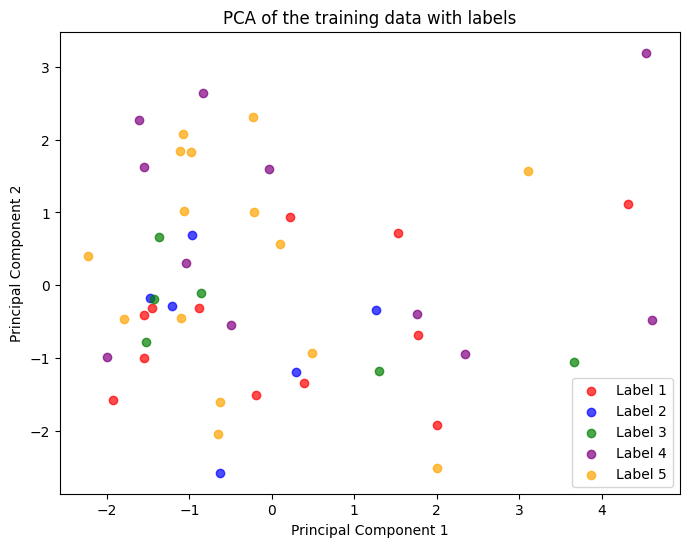

In [ ]:
# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_temp)

labels = df_train['condition_label'][:50]

label_colors = {1: 'red', 2: 'blue', 3: 'green', 4: 'purple', 5: 'orange'}

plt.figure(figsize=(8, 6))

for label in np.unique(labels):
    indices = np.where(labels == label)
    plt.scatter(principal_components[indices, 0], principal_components[indices, 1],
                label=f'Label {label}', color=label_colors[label], alpha=0.7)

plt.title('PCA of the training data with labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

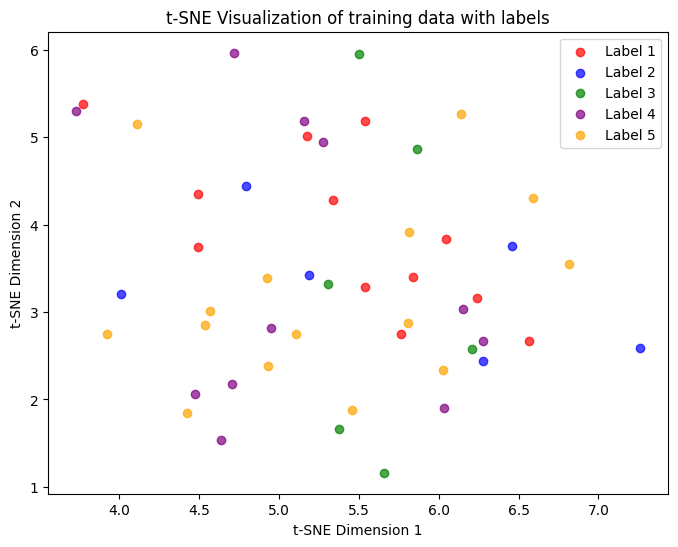

In [ ]:
data = features_temp.copy()[:50]
labels = df_train['condition_label'][:50]

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
embedded_data = tsne.fit_transform(data)

# Plot the t-SNE visualization with color-coded labels
plt.figure(figsize=(8, 6))

for label in np.unique(labels):
    indices = np.where(labels == label)
    plt.scatter(embedded_data[indices, 0], embedded_data[indices, 1],
                label=f'Label {label}', color=label_colors[label], alpha=0.7)

plt.title('t-SNE Visualization of training data with labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()

As before, there are no discernible patterns, suggesting that this BERT may not increase classification performance compared to the previous two options.

# ClinicalBERT

Finally, we examine the ClinicalBERT model (found on HuggingFace [here](https://huggingface.co/medicalai/ClinicalBERT) and from Wang et al. in [this article](https://www.nature.com/articles/s41591-023-02552-9) in 2023). This was initialised from BERT and then trained on a large multicenter dataset with a large corpus of 1.2B words of diverse diseases, created by the authors.

Like Bio_ClinicalBERT, this appears to be a much larger model, so we will just embed and analyse a fraction of the data.

We load the tokenizer and model.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")
model = AutoModel.from_pretrained("medicalai/ClinicalBERT")

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/542M [00:00<?, ?B/s]

We truncate and process the data for embedding as before.

In [ ]:
tokenized = df_train.medical_abstract.apply((lambda x: tokenizer.encode(truncate_to_n_words(x, 200), add_special_tokens=True)))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

We define our embedding function.

In [ ]:
def embed_with_BERT(padded, attention_mask):

  input_ids = torch.tensor(padded)
  attention_mask_tensor = torch.tensor(attention_mask)

  with torch.no_grad():
      last_hidden_states = model(input_ids, attention_mask=attention_mask_tensor)

  return last_hidden_states[0][:,0,:].numpy()

We embed the first 50 data examples. (Below takes 1 min.)

In [ ]:
i=0
step=50
features_temp = embed_with_BERT(padded[i:i+step], attention_mask[i:i+step])

Again, we found that increasing batch size to 350 in the above caused a RAM overflow issue, indicating the larger the size of this model.

We perform a PCA and t-SNE.

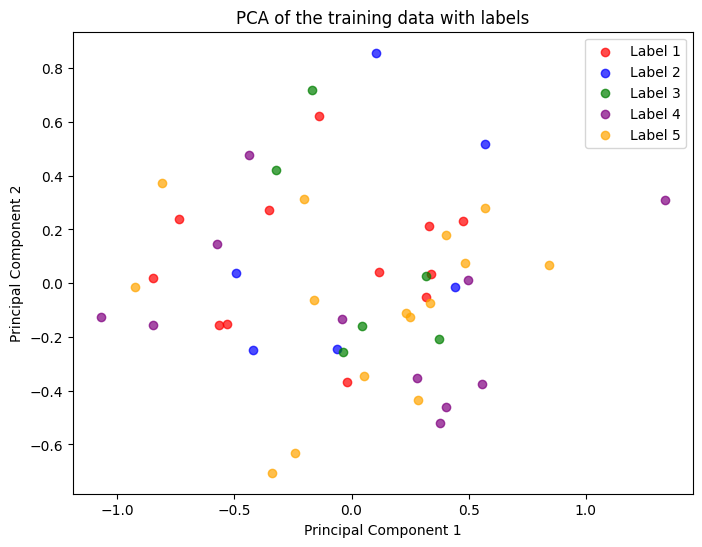

In [ ]:
# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_temp)

labels = df_train['condition_label'][:50]

label_colors = {1: 'red', 2: 'blue', 3: 'green', 4: 'purple', 5: 'orange'}

plt.figure(figsize=(8, 6))

for label in np.unique(labels):
    indices = np.where(labels == label)
    plt.scatter(principal_components[indices, 0], principal_components[indices, 1],
                label=f'Label {label}', color=label_colors[label], alpha=0.7)

plt.title('PCA of the training data with labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

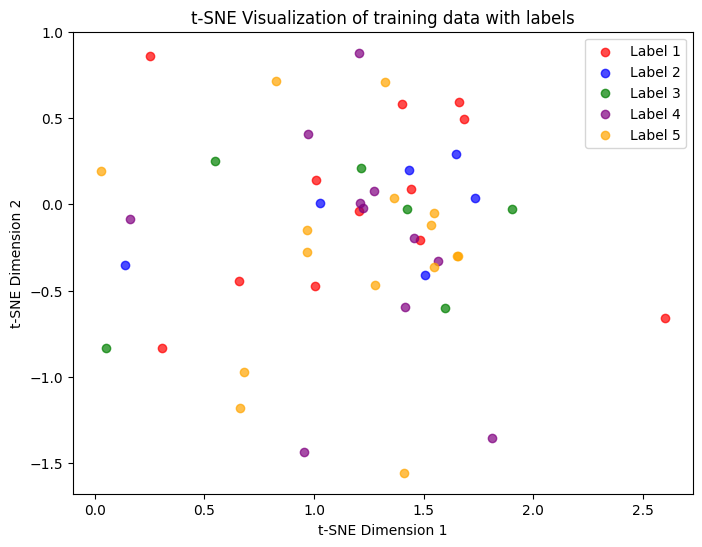

In [ ]:
data = features_temp.copy()[:50]
labels = df_train['condition_label'][:50]

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
embedded_data = tsne.fit_transform(data)

# Plot the t-SNE visualization with color-coded labels
plt.figure(figsize=(8, 6))

for label in np.unique(labels):
    indices = np.where(labels == label)
    plt.scatter(embedded_data[indices, 0], embedded_data[indices, 1],
                label=f'Label {label}', color=label_colors[label], alpha=0.7)

plt.title('t-SNE Visualization of training data with labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()

As before, there are no discernible patterns here, suggesting this model would not do any better at classifying the abstracts than the others.

# Dummy classifier

As a final check, we define a 'dummy' classifier that assigns to each abstract one of the five classes, chosen uniformly at random.

In [ ]:
def dummy_classifier(predicted_probs):
  x = predicted_probs.shape[0]
  predicted_classes = np.zeros(x)
  for i in range(x):
    u = np.random.uniform()
    if u < 0.2:
      predicted_classes[i] = 0
    elif u < 0.4:
      predicted_classes[i] = 1
    elif u < 0.6:
      predicted_classes[i] = 2
    elif u < 0.8:
      predicted_classes[i] = 3
    else:
      predicted_classes[i] = 4
  return predicted_classes

We use this to 'predict' the test data and report the performance.

In [ ]:
predicted_classes = dummy_classifier(predicted_probs)

In [ ]:
# Convert PyTorch tensors to NumPy arrays
labels_np = df_test['condition_label'].to_numpy().copy()
labels_np -= 1
predicted_classes_np = predicted_classes

# Evaluate the performance
accuracy = accuracy_score(labels_np, predicted_classes_np)
conf_matrix = confusion_matrix(labels_np, predicted_classes_np)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.19598337950138503
Confusion Matrix:
[[ 99 121 129 161 123]
 [ 61  63  66  51  58]
 [ 71  83  66  95  70]
 [126 116 117 130 121]
 [190 192 183 188 208]]


In [ ]:
performance(conf_matrix)

NEOPLASMS
Precision: 0.18, Recall: 0.16
DIGESTIVE SYSTEM DISEASES
Precision: 0.11, Recall: 0.21
NERVOUS SYSTEM DISEASES
Precision: 0.12, Recall: 0.17
CARDIOVASCULAR DISEASES
Precision: 0.21, Recall: 0.21
GENERAL PATHOLOGICAL CONDITIONS
Precision: 0.36, Recall: 0.22
Total Accuracy: 0.196


Perhaps as expected, we see very bad results here, with a total accuracy of around 20%.

However, this is encouraging for our BERT model! Although BERT did not have hugely high accuracy, it was better than this dummy classifier. This indicates that it is still more informed than classifying the medical abstracts completely randomly, suggesting that there is at least some useful information in the latent representations outputted by BERT models.